# How many rRNA runs in previous tRNA seq runs

Daniel asks:

    Hi Aaaron,

    could you again send me the percentage of rRNA reads in the first and second tRNA-sequencing run that we did last year?

    Thanks and best,

    Daniel
    
These are data from 2016-08-19-HG3W5AFXX and 2016-10-12-HGWGFAFXX

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

In [1]:
suppressMessages({
    .libPaths(c("/g/steinmetz/brooks/anaconda/lib/R/library",
               "/g/steinmetz/brooks/R/x86_64-pc-linux-gnu-library/3.3",
               "/root/anaconda3/envs/jupyter/lib/R/library"))
    # config opts and libraries
    options(repr.plot.width = 6)
    options(repr.plot.height = 5)
    options(jupyter.plot_mimetypes = 'image/png')
    library(readr)
    library(wasabi)
    library(sleuth)
    library(pheatmap)
    library(forcats)
    library(ggExtra)
    library(LSD)
    library(MASS)
    library(ggrepel)
    library(tidyr)
    library(ggplot2)
    library(plyr)
    library(dplyr)
    library(stringr)
    #library(reshape2)
    library(parallel)
    options(mc.cores = 24)
    #library(stringr)
    library(RColorBrewer)
    library(tidyr)
    library(forcats)
    library(tibble)
    
    library(webreadr)
    library(ggforce)
    #ibrary(ggraph)
    library(ggthemes)
    library(plotly)
    #devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/seqtools.R")
})

Warning message:
“package ‘stringr’ was built under R version 3.4.2”

In [2]:
suppressMessages({
    sample2ezname = function(x) {
        o = x
        o[x == "S1"] = "BY4741+neo"
        o[x == "S2"] = "BY4741"
        o[x == "S3"] = "triple-syn+neo"
        o[x == "S4"] = "triple-syn"
        return(o)
    }
    sample2reference = function(x) {
        o = x
        o[x == "BY4741+neo"] = "BY4741"
        o[x == "BY4741"] = "BY4741"
        o[x == "triple-syn+neo"] = "triple-syn"
        o[x == "triple-syn"] = "triple-syn"
        return(o)
    }
    chr2ezname = function(x) {
        o = x
        o[x == "chr17"] = "mito"
        o[x == "chr18"] = "neo"
        return(o)
    }
    RESULTS = "/g/steinmetz/project/IESY/trna/results/2016-10-12-HGWGFAFXX/salmon/combined"
    results = readRDS(file.path(RESULTS, "results.rds"))

    # Add tRNA intron annotations
    if (is.null(results$intron)) {
        # load tRNA intron annotations
        intron_trnas = read_tsv("/g/steinmetz/project/IESY/trna/data/trna_Gene_FeatureType_Introns.tsv")
        # convert chr names to arabic numbers
        intron_trnas$Gene.chromosomeLocation.locatedOn.primaryIdentifier = 
            roman2arabic(intron_trnas$Gene.chromosomeLocation.locatedOn.primaryIdentifier)
        intron_trnas$Isotype = sapply(intron_trnas$Gene.secondaryIdentifier, function(j) {
            gsub("[\\(\\)]", "", regmatches(j, gregexpr("\\(.*?\\)", j))[[1]])
                 })
        intron_trnas = mutate(intron_trnas, Isotype = gsub("U","T",Isotype))
        # add intron annotations to results table
        results$intron = apply(results, 1, function(i){
           # print(i)
            thisisotype = i[["Isotype"]]
            thischr = i[["seqid"]]
            subintrons = intron_trnas %>% 
                            filter(Isotype==thisisotype, 
                                     Gene.chromosomeLocation.locatedOn.primaryIdentifier==thischr)
            if (dim(subintrons)[1]>0) {
                ss = as.numeric(i[["start"]])
                ee = as.numeric(i[["end"]])
                subintrons = subintrons %>% 
                             mutate(sdist = abs(Gene.chromosomeLocation.start - ss),
                                edist = abs(Gene.chromosomeLocation.end - ee)) %>% 
                             arrange(sdist,edist)
                if (dim(subintrons)[1]==1) {
                    if (subintrons$sdist<20000 && subintrons$edist<20000) {
                        return(T)
                    } else {
                        return(F)
                    }
                } else {
                    #print("More than one on a chr. Taking first (closest match)")
                    subintrons = subintrons[1,]
                    if (subintrons$sdist<20000 && subintrons$edist<20000) {
                        return(T)
                    } else {
                        return(F)
                    }
                }
            } else {
                return(F)
            }
        })
    }
})
results$type = sapply(results$type, function(i) gsub("_gene", "",i))
trnas = results %>% filter(grepl("tRNA",Name))
trnas$ezseqid[is.na(trnas$ezseqid)] = "Mature"

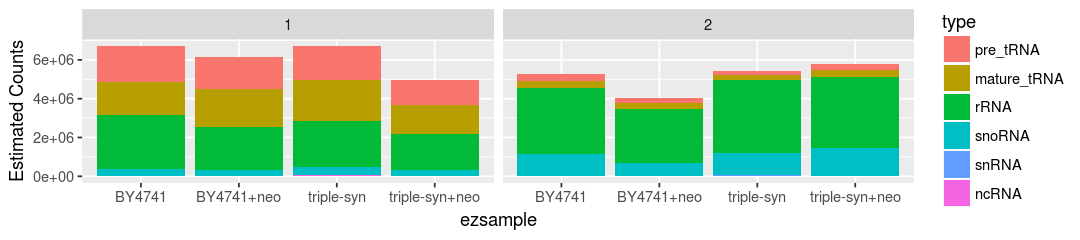

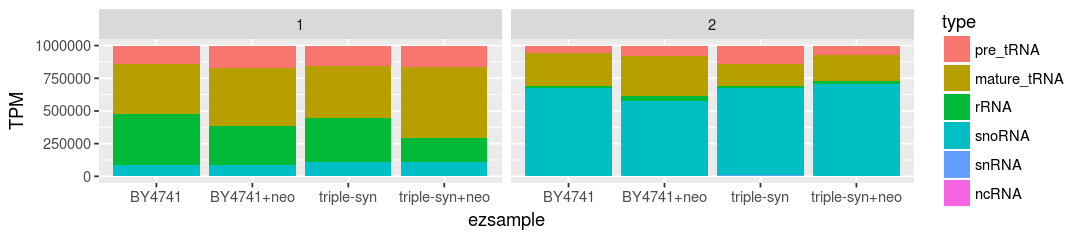

In [3]:
options(repr.plot.width = 9)
options(repr.plot.height = 2)
results$type = factor(results$type, levels = (c(
"pre_tRNA",
"mature_tRNA",
"rRNA",
"snoRNA",
"snRNA",
"ncRNA")))

p <- ggplot(results %>% group_by(type, ezsample, replicate) %>% summarise(sum=sum(NumReads))) + 
geom_bar(aes(y = sum, x = ezsample, 
    fill = type), stat = "identity") +
    ylab("Estimated Counts") + facet_wrap (~ replicate, ncol=2)
p

p2 <- ggplot(results %>% group_by(type, ezsample, replicate) %>% summarise(sum=sum(TPM))) + 
geom_bar(aes(y = sum, x = ezsample, 
    fill = type), stat = "identity") +
    ylab("TPM") + facet_wrap (~ replicate, ncol=2)
p2

# rRNA reads across samples

In [5]:
counts = results %>% filter(type == "rRNA") %>% group_by(ezsample, replicate) %>% 
    summarise(NumReads=sum(NumReads), TPM=sum(TPM))
counts

ezsample,replicate,NumReads,TPM
BY4741,1,2783031,390356.77
BY4741,2,3442210,19486.97
BY4741+neo,1,2231883,294762.49
BY4741+neo,2,2798472,38843.44
triple-syn,1,2380069,331007.77
triple-syn,2,3771691,14933.94
triple-syn+neo,1,1885372,182511.37
triple-syn+neo,2,3661961,15968.63
